In [1]:
import pandas as pd
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from utils.pandas_dataframe import grid_display
import missingno as msno
import numpy as np
import pickle

###############
#### model ####
###############
# pca
from sklearn.decomposition import PCA

# outlier detection
from pyod.models.ecod import ECOD
from pyod.models.suod import SUOD
from pyod.models.lof import LOF
from pyod.models.iforest import IForest
from pyod.models.copod import COPOD
from sklearn.covariance import EllipticEnvelope

%matplotlib inline

In [2]:
data = pd.read_excel('../Data/2022-train-v2.xlsx')

In [3]:
print(f"train shape : {data.shape}")

train shape : (635, 131)


In [4]:
# for i in df.columns:
#     print(i)

In [5]:
data_y = data[['sensor_point5_i_value', 'sensor_point6_i_value', 'sensor_point7_i_value', 'sensor_point8_i_value', 'sensor_point9_i_value', 'sensor_point10_i_value']]
data_x = data.drop(['sensor_point5_i_value', 'sensor_point6_i_value', 'sensor_point7_i_value', 'sensor_point8_i_value', 'sensor_point9_i_value', 'sensor_point10_i_value'], axis=1)
del data

## 1. Target variable

In [6]:
data_y.head()

,sensor_point5_i_value,sensor_point6_i_value,sensor_point7_i_value,sensor_point8_i_value,sensor_point9_i_value,sensor_point10_i_value
0,42,56,82,41,73,45
1,37,60,58,40,64,42
2,35,66,62,39,86,45
3,37,58,58,42,52,39
4,57,78,62,51,64,65


In [7]:
data_y.shape

(635, 6)

We have multiple outputs that need to predict. The simple solution is using multioutput regression.

### Check data type

In [8]:
data_y.dtypes

sensor_point5_i_value     int64
sensor_point6_i_value     int64
sensor_point7_i_value     int64
sensor_point8_i_value     int64
sensor_point9_i_value     int64
sensor_point10_i_value    int64
dtype: object

### Check target variables' patterns

In [9]:
y_desc = data_y.describe()
y_nunique = pd.DataFrame(data_y.apply(lambda x: x.nunique()), columns=['nunique'])
list_df = [   
    y_desc.loc[['count']].T.style.background_gradient(
        vmin=0, vmax=640, cmap=sns.color_palette("vlag", as_cmap=True)),
    
    y_nunique.style.background_gradient(
        vmin=0, vmax=120, cmap=sns.color_palette("vlag", as_cmap=True)),
    
    y_desc.loc[['mean']].T.style.background_gradient(
        vmin=0, vmax=120, cmap=sns.color_palette("vlag", as_cmap=True)),
    
    y_desc.loc[['std']].T.style.background_gradient(
        vmin=0, vmax=30, cmap=sns.color_palette("vlag", as_cmap=True)),
    
    y_desc.loc[['min']].T.style.background_gradient(
        vmin=0, vmax=55, cmap=sns.color_palette("vlag", as_cmap=True)),

    y_desc.loc[['max']].T.style.background_gradient(
        vmin=0, vmax=270, cmap=sns.color_palette("vlag", as_cmap=True)),
    
    y_desc.loc[['25%', '50%', '75%']].T.style.background_gradient(
        vmin=0, vmax=130, cmap=sns.color_palette("vlag", as_cmap=True)),
]

grid_display(
    list_df, 
    list_df_name=['', '', '', '', '', '', ''],
    list_number_of_data=[6, 6, 6, 6, 6, 6, 6],
    row = 2, col = 4, fill = 'row'
)

,count
sensor_point5_i_value,635.000000
sensor_point6_i_value,635.000000
sensor_point7_i_value,635.000000
sensor_point8_i_value,635.000000
sensor_point9_i_value,635.000000
sensor_point10_i_value,635.000000
,nunique
sensor_point5_i_value,69
sensor_point6_i_value,108
sensor_point7_i_value,111


In [39]:
# fig, axes = plt.subplots(len(data_y.columns),2, figsize=(12, len(data_y.columns)*4))
# for i, col in enumerate(data_y.columns):
#     sns.histplot(data_y[col], ax=axes[i,0], kde =True)

#     # these are matplotlib.patch.Patch properties
#     props = dict(boxstyle='round', facecolor='wheat', alpha=0.5, pad=0.5)
#     # place a text box in upper left in axes coords
#     axes[i,0].text(
#         0.65, 0.90,
#         f'Skewness: {data_y.skew()[col]:.3f}\nKurtosis: {data_y.kurt()[col]:.3f}',
#         transform=axes[i,0].transAxes,
#         fontsize=12,
#         verticalalignment='top',
#         bbox=props)

    
#     sm.qqplot(data_y[col].dropna(), line='s', fmt='b', ax=axes[i,1])
#     axes[i, 1].set_title(col)

# plt.tight_layout()
# plt.savefig('../Img/data_y.png', facecolor='white')

![data_y](../Img/data_y.png "data_y")

#### Note:
* Skewness: 
    1. Negative skew commonly indicates that the tail is on the left side of the distribution.
    2. Positive skew indicates that the tail is on the right.
    3. A zero value means that the tails on both sides of the mean balance out overall
* Kurtosis:     
    1. Negative values of kurtosis means the distribution produces fewer and/or less extreme outliers than the normal distribution. 
    2. Positive values of kurtosis has tails that asymptotically approach zero more slowly than a Gaussian, and therefore produces more outliers than the normal distribution.

>#### Note:
>* Skewness: 
    1. Negative skew commonly indicates that the tail is on the left side of the distribution.
    2. Positive skew indicates that the tail is on the right.
    3. A zero value means that the tails on both sides of the mean balance out overall
>* Kurtosis:     
    1. Negative values of kurtosis means the distribution produces fewer and/or less extreme outliers than the normal distribution. 
    2. Positive values of kurtosis has tails that asymptotically approach zero more slowly than a Gaussian, and therefore produces more outliers than the normal distribution.


#### Coclusion:
1. Except for `sensor_point5_i_value`, there all have positive skewness.
2. Target variables seem like the normal distribution, but they still have outliers.
#### Action
At least deal with outliers on the right side.

### Check missing values

In [11]:
print('Whether dataset has null values: ', np.isnan(data_y.values).any())

Whether dataset has null values:  False


In [12]:
# # Check missing values patterns
# msno.matrix(data_y),
# msno.bar(data_y),
# msno.heatmap(data_y),
# msno.dendrogram(data_y)

### Outlier detection
#### ECOD
* [Reference](https://arxiv.org/abs/2201.00382)
* [Medium Explain](https://medium.com/geekculture/replace-outlier-detection-by-simple-statistics-with-ecod-f95a7d982f79)

A higher anomaly score indicates that there is a lower probability of an observation because it lies further along the tail of the data distribution.

In [13]:
clf_name = 'ECOD'
clf = ECOD(contamination=0.03)
# The contamination indicates the expected percentage of outliers in the training data.
clf.fit(data_y)
# get outlier scores
ecod_outlier_score = clf.decision_scores_

#### To get outlier predictions from ECOD, there are three options:
1. Set a threshold on the outlier scores; any row with a score that exceeds the threshold is an anomaly
2. Select to top-k or top-kth-percentile outlier scores
3. Hand-pick a threshold

#### Threshold by hand-selecting

In [14]:
-np.log10(0.01)*6

12.0

#### SUOD

In [15]:
# initialized a group of outlier detectors for acceleration
detector_list = [LOF(n_neighbors=15), LOF(n_neighbors=20),
                 LOF(n_neighbors=25), LOF(n_neighbors=35),
                 COPOD(), IForest(n_estimators=100),
                 IForest(n_estimators=200)]

# decide the number of parallel process, and the combination method
# then clf can be used as any outlier detection model
clf = SUOD(base_estimators=detector_list,
           n_jobs=2,
           combination='average',
           verbose=False)

clf.fit(data_y)  # fit all models with X
sudo_outlier_score = clf.decision_function(data_y)  # predict scores

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    6.6s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    6.6s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    6.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    6.0s finished


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    5.7s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    5.7s finished


#### Elliptic Envelope
An object for detecting outliers in a Gaussian distributed dataset.

In [16]:
cov = EllipticEnvelope(random_state=0).fit(data_y)
# predict returns 1 for an inlier and -1 for an outlier
elliptic_envelope_score = cov.predict(data_y)

In [17]:
outlier_score_df = pd.DataFrame()
outlier_score_df['ecod_outlier_score'] = ecod_outlier_score
outlier_score_df['sudo_outlier_score'] = sudo_outlier_score
outlier_score_df['elliptic_envelope_score'] = elliptic_envelope_score

In [18]:
outlier_score_df.describe()

,ecod_outlier_score,sudo_outlier_score,elliptic_envelope_score
count,635.000000,635.000000,635.000000
mean,9.802765,-0.013431,0.798425
std,2.919751,0.709406,0.602569
min,5.006007,-0.879562,-1.000000
25%,7.715258,-0.468428,1.000000
50%,9.272117,-0.190569,1.000000
75%,10.928099,0.195978,1.000000
max,24.129211,5.498090,1.000000


#### Use PCA reduce dimension to 2 and find out outlier threshold

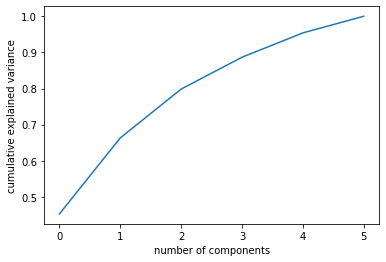

In [19]:
pca = PCA().fit(data_y)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
#從下圖可以看出降維到40，訊息損失是還可以接受的

In [20]:
# If 0 < n_components < 1 ，數字則代表要限制在多少 variance
# 大於等於1的話就是看要降到幾維
pca_model = PCA(0.65) # keep 95% of variance 只維持95%的分散程度，看可以降到幾維
data_y_pca = pca_model.fit_transform(data_y)
print('old dim: ', data_y.shape)
print('new dim: ', data_y_pca.shape)  

old dim:  (635, 6)
new dim:  (635, 2)


In [21]:
with open('../Model/pca_model.pickle', 'wb' ) as f:
    pickle.dump(pca_model, f)

In [22]:
with open('../Model/pca_model.pickle', 'rb') as f:
    pca_model = pickle.load(f)

In [23]:
# Use PCA Transform training data
data_y_pca = pca_model.transform(data_y)

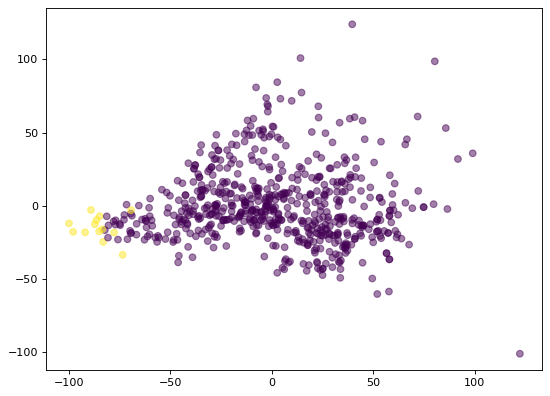

In [24]:
x = data_y_pca[:,0]
y = data_y_pca[:,1]
colors = (outlier_score_df['ecod_outlier_score']>18).astype(int)
# area = (30 * np.random.rand(N))**2  # 0 to 15 point radii
plt.figure(figsize=(8, 6), dpi=80)
plt.scatter(x, y, alpha=0.5, c=colors)

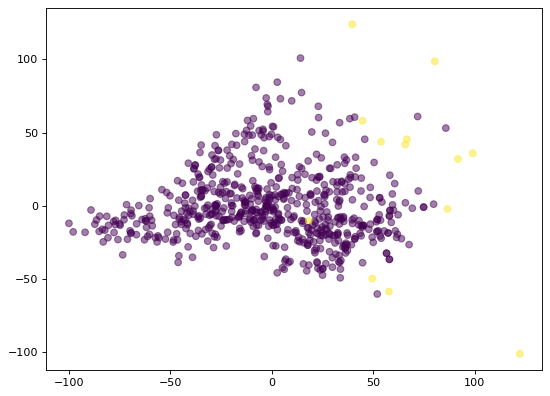

In [25]:
x = data_y_pca[:,0]
y = data_y_pca[:,1]
colors = (outlier_score_df['sudo_outlier_score']>2).astype(int)
# area = (30 * np.random.rand(N))**2  # 0 to 15 point radii
plt.figure(figsize=(8, 6), dpi=80)
plt.scatter(x, y, alpha=0.5, c=colors)

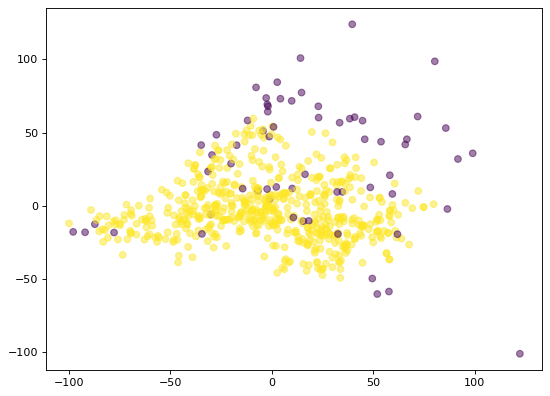

In [26]:
x = data_y_pca[:,0]
y = data_y_pca[:,1]
colors = outlier_score_df['elliptic_envelope_score']
# area = (30 * np.random.rand(N))**2  # 0 to 15 point radii
plt.figure(figsize=(8, 6), dpi=80)
plt.scatter(x, y, alpha=0.5, c=colors)

## 2. Independent variable

In [27]:
data_x.head()

,clean_temp,clean_ec,clean_ph4,clean_ph5,clean_ph7,clean_ph8,clean_pressure11,clean_pressure12,clean_pressure21,clean_pressure22,...,env_rpi14_pm1,env_rpi14_pm10,env_rpi14_pm25,env_rpi14_temp,env_rpi15_hum,env_rpi15_lux,env_rpi15_pm1,env_rpi15_pm10,env_rpi15_pm25,env_rpi15_temp
0,41.1,12.4,NaN,NaN,NaN,6.9,820.24,1262.82,883.46,630.74,...,26.33,47.50,37.33,34.41,43.73,0.50,29.50,51.50,42.00,34.78
1,41.1,12.4,NaN,NaN,NaN,6.9,820.15,1263.00,883.60,630.70,...,26.33,47.50,37.33,34.41,43.73,0.50,29.50,51.50,42.00,34.78
2,41.1,12.4,NaN,NaN,NaN,6.9,820.15,1263.00,883.60,630.70,...,26.33,47.50,37.33,34.41,43.73,0.50,29.50,51.50,42.00,34.78
3,41.1,12.4,NaN,NaN,NaN,6.9,820.15,1263.00,883.60,630.70,...,26.33,47.50,37.33,34.41,43.73,0.50,29.50,51.50,42.00,34.78
4,41.1,12.4,NaN,NaN,NaN,6.9,820.78,1264.00,883.31,630.74,...,26.71,48.85,38.14,34.48,43.94,0.42,29.71,51.85,42.42,34.82


In [28]:
data_x.shape

(635, 125)

In [29]:
data_x.dtypes

clean_temp        float64
clean_ec          float64
clean_ph4         float64
clean_ph5         float64
clean_ph7         float64
                   ...   
env_rpi15_lux     float64
env_rpi15_pm1     float64
env_rpi15_pm10    float64
env_rpi15_pm25    float64
env_rpi15_temp    float64
Length: 125, dtype: object

In [30]:
x_desc = data_x.describe()
x_nunique = pd.DataFrame(data_x.apply(lambda x: x.nunique()), columns=['nunique'])
list_df = [   
    x_desc.loc[['count']].T.style.background_gradient(
        vmin=0, vmax=640, cmap=sns.color_palette("vlag", as_cmap=True)),
    
    x_nunique.style.background_gradient(
        vmin=0, vmax=x_nunique['nunique'].max(), cmap=sns.color_palette("vlag", as_cmap=True)),
    
    x_desc.loc[['mean']].T.style.background_gradient(
        vmin=0, vmax=x_desc.loc[['mean']].T.max(), cmap=sns.color_palette("vlag", as_cmap=True)),
    
    x_desc.loc[['std']].T.style.background_gradient(
        vmin=0, vmax=x_desc.loc[['std']].T.max(), cmap=sns.color_palette("vlag", as_cmap=True)),
    
    x_desc.loc[['min']].T.style.background_gradient(
        vmin=0, vmax=x_desc.loc[['min']].T.max(), cmap=sns.color_palette("vlag", as_cmap=True)),

    x_desc.loc[['max']].T.style.background_gradient(
        vmin=0, vmax=x_desc.loc[['max']].T.max(), cmap=sns.color_palette("vlag", as_cmap=True)),
    
    x_desc.loc[['25%', '50%', '75%']].T.style.background_gradient(
        vmin=0, vmax=x_desc.loc[['75%']].T.max(), cmap=sns.color_palette("vlag", as_cmap=True)),
]

grid_display(
    list_df, 
    list_df_name=['', '', '', '', '', '', ''],
    list_number_of_data=[6, 6, 6, 6, 6, 6, 6],
    row = 2, col = 4, fill = 'row'
)

,count
clean_temp,635.000000
clean_ec,635.000000
clean_ph4,349.000000
clean_ph5,349.000000
clean_ph7,349.000000
clean_ph8,635.000000
clean_pressure11,635.000000
clean_pressure12,635.000000
clean_pressure21,635.000000
clean_pressure22,635.000000


* count: `clean_ph4`、`clean_ph5`、`clean_ph7` 有大量空值
* nunique: 有很多變數的值有集中在特定幾個數值上的現象;或是有大量的 0
* mean: 平均數差異很大，一定要做標準化
* std: `clean_pressure102`在平均數為 269.550787 的水準下，標準差有 213.829343，還有很多其他變數也是如此
* min: 沒有負值

<AxesSubplot:>

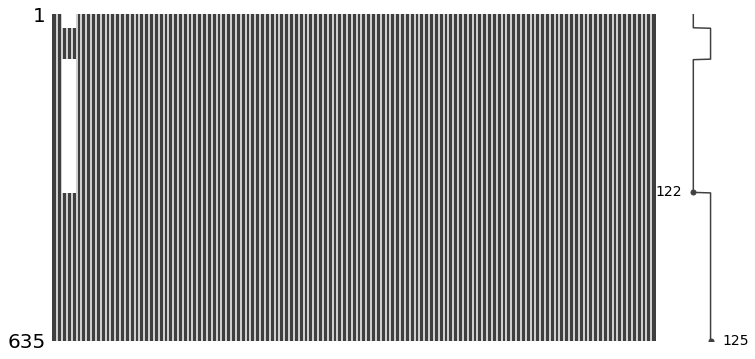

In [31]:
msno.matrix(data_x, figsize=(12, 6))

<AxesSubplot:>

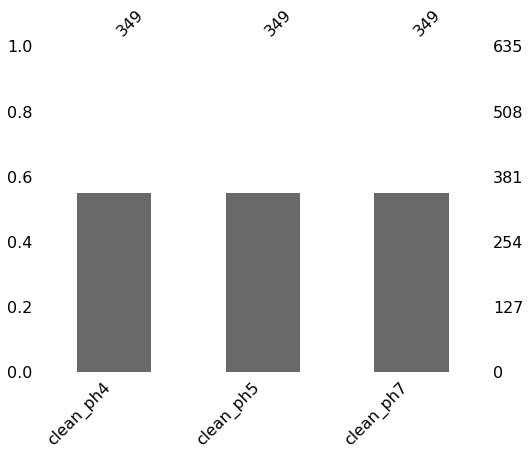

In [32]:
msno.bar(data_x.iloc[:, 2:5], figsize=(8, 6))

<AxesSubplot:>

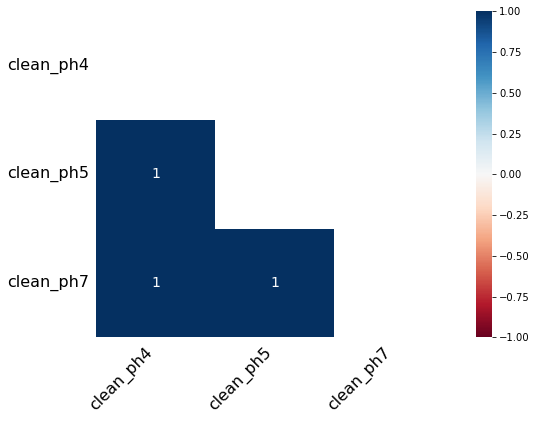

In [33]:
msno.heatmap(data_x, figsize=(8, 6))

In [34]:
# msno.dendrogram(data_x, figsize=(8, 15))

In [35]:
#取得數值型態的欄位
numeric_data = data_x._get_numeric_data()
numeric_data.columns

Index(['clean_temp', 'clean_ec', 'clean_ph4', 'clean_ph5', 'clean_ph7',
       'clean_ph8', 'clean_pressure11', 'clean_pressure12', 'clean_pressure21',
       'clean_pressure22',
       ...
       'env_rpi14_pm1', 'env_rpi14_pm10', 'env_rpi14_pm25', 'env_rpi14_temp',
       'env_rpi15_hum', 'env_rpi15_lux', 'env_rpi15_pm1', 'env_rpi15_pm10',
       'env_rpi15_pm25', 'env_rpi15_temp'],
      dtype='object', length=125)

### Check distribution on each independent variable

In [38]:
# fig, axes = plt.subplots(len(data_x.columns),2, figsize=(12, len(data_x.columns)*4))
# for i, col in enumerate(data_x.columns):
#     sns.histplot(data_x[col], ax=axes[i,0], kde =True)

#     # these are matplotlib.patch.Patch properties
#     props = dict(boxstyle='round', facecolor='wheat', alpha=0.5, pad=0.5)
#     # place a text box in upper left in axes coords
#     axes[i,0].text(
#         0.65, 0.90,
#         f'Skewness: {data_x.skew()[col]:.3f}\nKurtosis: {data_x.kurt()[col]:.3f}',
#         transform=axes[i,0].transAxes,
#         fontsize=12,
#         verticalalignment='top',
#         bbox=props)

    
#     sm.qqplot(data_x[col].dropna(), line='s', fmt='b', ax=axes[i,1])
#     axes[i, 1].set_title(col)

# plt.tight_layout()
# plt.savefig('../Img/data_x.png', facecolor='white')

![data_x](../Img/data_x.png "data_x")

### Check Linear correlation on independent variable

In [58]:
# fig, ax = plt.subplots(figsize=(25,20))
# sns.heatmap(data_x.corr(), annot = False, fmt='.2g',cmap= 'coolwarm',linewidth=0.1, ax=ax)
# plt.tight_layout()
# plt.savefig('../Img/data_x_corr.png', facecolor='white')

![data_x_corr](../Img/data_x_corr.png "data_x_corr")

越紅代表越有線性相關，在變數挑選上要妥善處理